# Listing Price

There are many features that are just informative in nature. To reduce the dimentianllity let us remove such columns from the data.

In [30]:
# Run dataprocessing Notebook
%run dataprocessing.ipynb

# Select relavent features for analysis
selected_vars = ['id', 'experiences_offered',
       'transit', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'market', 
       'zipcode', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability',
       'number_of_reviews',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'requires_license', 
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'reviews_per_month']

In [22]:
# Load csv into dataframes
listing_df= pd.read_csv('..//data//listings.csv')

X,y = data_wrangling(listing_df,selected_vars)

Index(['id', 'host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'Facilities',
       'Host_experience'],
      dtype='object')
Index(['zipcode', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy'],
      dtype='object')


In [23]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
#lm_model = RandomForestRegressor(max_depth=20, n_estimators=1000,random_state=False, verbose=False)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#append the r2 value from the test set
r2_scores_test= (r2_score(y_test, y_test_preds))
r2_scores_train= (r2_score(y_train, y_train_preds))
results= r2_score(y_test, y_test_preds)

In [24]:
print(results)

0.6140083807584416


In [25]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
print(coef_df.head(10))

                  est_int       coefs   abs_coefs
62     property_type_Boat  101.869130  101.869130
58          zipcode_98178  -89.304988   89.304988
57          zipcode_98177  -82.022882   82.022882
52          zipcode_98133  -66.059216   66.059216
56          zipcode_98146  -65.680403   65.680403
50          zipcode_98125  -62.301484   62.301484
68     property_type_Dorm  -62.141143   62.141143
53          zipcode_98134   60.110094   60.110094
38          zipcode_98106  -58.506031   58.506031
77  room_type_Shared room  -54.534841   54.534841


# Results

1. property_type_Boat
2. Zipcode 
3. Room Type


## Price by Month of the year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null float64
Month         1393570 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 53.2+ MB


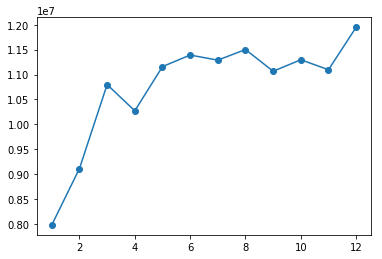

In [31]:
# Load csv into dataframes
calender_df= pd.read_csv('..//data//calendar.csv')

get_float_val(calender_df['price'])

def count_days_since(oldDate):
    return oldDate.month
# host since
calender_df['Month'] = pd.to_datetime(calender_df.date).apply(count_days_since)
calender_df['price'] = calender_df['price'].astype(dtype='float')
calender_df['Month'] = calender_df['Month'].astype(dtype='float')
calender_df.info()

datas = calender_df.groupby(['Month']).price.sum()

#Step 1 - Prepare Data
data = calender_df

#Step 2 - Create Plot
fig = plt.figure()

#Step 3 - Plot
ax = fig.add_subplot(111)

#Step 4 - Customize plot
ax.plot(datas,marker='o')

#Step 5 - plt.show()
plt.show()


## Price by Zipcodes

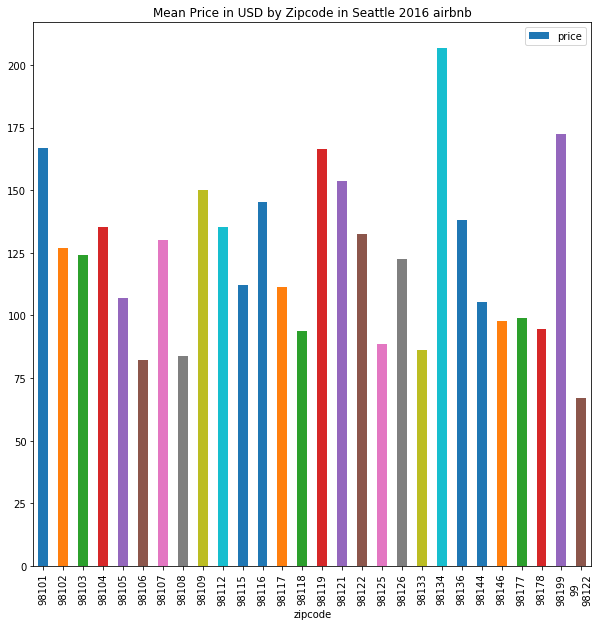

In [32]:
# Load csv into dataframes
listings_df= pd.read_csv('..//data//listings.csv')

listings_df['price'] = get_float_val(listings_df['price'])
listings_df['price'] = listings_df['price'].astype(dtype='float')
plotg = listings_df.groupby(['zipcode']).price.mean()

import matplotlib.pyplot as plt
_ = plotg.plot(kind='bar',figsize=(10,10),title='Mean Price in USD by Zipcode in Seattle 2016 airbnb',y= 'Mean Price in $',legend=True)